In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GRU, GlobalAveragePooling1D

### Load data

technical data : [link](https://mysterious-hollows-20657.herokuapp.com/)

In [127]:
raw_skills = pd.read_csv('/content/drive/MyDrive/Skills_classification/Files/Raw_Skills_Dataset.csv')
technical_skills = pd.read_csv('/content/drive/MyDrive/Skills_classification/Files/Example_Technical_Skills.csv')
soft_skills = pd.read_csv('/content/drive/MyDrive/Skills_classification/Files/softskill.csv')

In [128]:
technical_skills.sample(n=10)

,Technology Skills
684,Oracle Cloud Integ Java Cloud Service SX
746,Apache Whirr
863,ServiceNow ITSM - Release
20,MS Bot Framework
898,PeopleSoft CS Academic Advisement
488,MobileIron
256,SAP Data Services
385,BPMN for Architecture
242,Murex (Cent. Bnks/Agncies) Conf & Deploy
640,SecureAuth


In [129]:
soft_skills.sample(n=10)

,soft_skill
157,exert a leadership role towards colleagues
159,explain technical details to non technical cus...
898,plan time
271,pay attention
823,weigh information
356,stimulate creativity in the team
904,memorise procedures
756,leading others
507,report facts
57,communicate well with people


In [130]:
raw_skills.sample(n=10)

,RAW DATA
5039,Excellent team collaboration and communicatio...
10933,Aggregations
6425,Bachelor degree
22867,software packages
1325,API Gateway
13007,OpenSSL
25004,plannings
4553,new functionality
5206,MVC web frameworks
7647,stream analytics technologies


### Generate Tokenize data from string lists.

Preprocessing ⁉
1. remove punctuation.
2. remove whitespace.
3. lower string.

then preprocessed string used for tokenisation.
we create vocabulary from only technical and soft skills data only not from raw data. so vocabulary have only usefull word for classification and remaining are goes into "OOV" token.
> we kept embedding dim as 6 and max length as 5 and padded tokenize sentences.



In [131]:
# generate tokenise data
print('     total words     unique words')

tech_data = [] # unique word
tech_seq = []  # string list
for s in technical_skills['Technology Skills']:
  s = s.translate(str.maketrans('', '', string.punctuation))
  s = s.strip()
  s = s.lower()
  tech_seq.append(s)
  for i in s.split():
    tech_data.append(i)

print('tech : ', len(tech_data),  '          ',  len(set(tech_data))) ## 

raw_data = [] # unique word
raw_seq = []  # string list
for s in raw_skills['RAW DATA']:
  s = s.translate(str.maketrans('', '', string.punctuation))
  s = s.strip()
  s = s.lower()
  raw_seq.append(s)
  for i in s.split():
    raw_data.append(i)

print('raw : ', len(raw_data),  '          ', len(set(raw_data))) ## 

soft_data = [] # unique word
soft_seq = []  # string list
for s in soft_skills['soft_skill']:
  s = s.translate(str.maketrans('', '', string.punctuation))
  s = s.strip()
  s = s.lower()
  soft_seq.append(s)
  for i in s.split():
    soft_data.append(i)

print('soft : ', len(soft_data), '          ',len(set(soft_data))) ## print 


fitt_data = list(set(soft_seq)) +  list(set(tech_seq))

vocab_size= len(fitt_data)
embd_size = 10
max_len = 6

tok = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(fitt_data)   ##
word_index = tok.word_index

tech_tok_seq = tok.texts_to_sequences(tech_seq)
tech_padded_seq = pad_sequences(tech_tok_seq, maxlen=max_len, padding='post', truncating='post')

soft_tok_seq = tok.texts_to_sequences(soft_seq)
soft_padded_seq = pad_sequences(soft_tok_seq, maxlen=max_len, padding='post', truncating='post')

raw_tok_seq = tok.texts_to_sequences(raw_seq)
raw_padded_seq = pad_sequences(raw_tok_seq, maxlen=max_len, padding='post', truncating='post')

     total words     unique words
tech :  3061            1305
raw :  71276            7690
soft :  3539            1013


### create trainable dataset from soft and tech skill

In [109]:
print('tech_padded : ', tech_padded_seq.shape)
print('soft_padded : ', soft_padded_seq.shape)

tech_padded :  (979, 6)
soft_padded :  (979, 6)


### create label:
            
> soft skill : 0


> hard skill : 1




            

In [132]:
X = np.vstack((tech_padded_seq, soft_padded_seq))

y1 = np.ones(979)
y0 = np.zeros(979)
y = np.concatenate((y1, y0), axis=0)

### shuffle data

In [133]:
import random
index = list(range(979))
random.shuffle(index)

In [134]:
X_s = X[index, :]
y_s = y[index]

X_s = np.asarray(X_s)
y_s = np.asarray(y_s)

### Build Model

Model Architecture 


> 1. Embedding layer with vocab_size, embd_size, input_length parameter defined above.


> 2. Bidirectional layer with GRU unit with 120 units.


> 3. Dense layer with 24 unit with 'relu' activation.


> 4. Final layer for classification have 1 unit with 'sigmoid'


For model compilation, 'binary crossentropy' as loss function, adam optimizer and we use accuracy as training tracking.










In [135]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embd_size, input_length=max_len),
    tf.keras.layers.Bidirectional(GRU(120)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 6, 10)             18650     
                                                                 
 bidirectional_3 (Bidirectio  (None, 240)              95040     
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 24)                5784      
                                                                 
 dense_24 (Dense)            (None, 1)                 25        
                                                                 
Total params: 119,499
Trainable params: 119,499
Non-trainable params: 0
_________________________________________________________________


### create validation data

In [136]:
val_index = random.sample(list(range(979)), 50)

X_val = X[val_index, :]
y_val = y[val_index]

In [ ]:
history = model.fit(X, y, epochs=100, validation_data=(X_val, y_val), batch_size=5, shuffle=True, verbose=2)

Epoch 1/100
392/392 - 9s - loss: 0.3255 - accuracy: 0.8320 - val_loss: 0.0800 - val_accuracy: 0.9800 - 9s/epoch - 22ms/step
Epoch 2/100
392/392 - 3s - loss: 0.0648 - accuracy: 0.9755 - val_loss: 0.0234 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 3/100
392/392 - 3s - loss: 0.0096 - accuracy: 0.9974 - val_loss: 1.2585e-04 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 4/100
392/392 - 3s - loss: 0.0069 - accuracy: 0.9985 - val_loss: 8.9410e-05 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 5/100
392/392 - 3s - loss: 0.0030 - accuracy: 0.9985 - val_loss: 3.3873e-05 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 6/100
392/392 - 3s - loss: 0.0070 - accuracy: 0.9980 - val_loss: 2.1762e-05 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 7/100
392/392 - 3s - loss: 0.0034 - accuracy: 0.9990 - val_loss: 5.7728e-05 - val_accuracy: 1.0000 - 3s/epoch - 8ms/step
Epoch 8/100
392/392 - 3s - loss: 1.5661e-04 - accuracy: 1.0000 - val_loss: 1.4060e-05 - val_accuracy: 1.0000 - 3s/epoc

### Plot Training

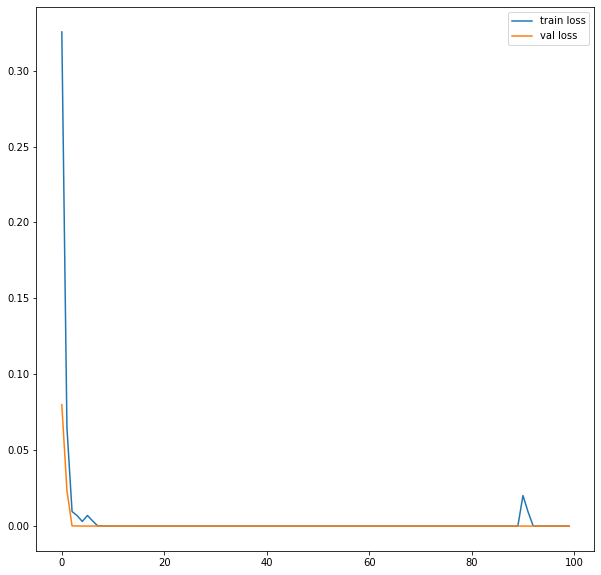

In [138]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### Prediction raw data

In [139]:
pred = model.predict(raw_padded_seq)

### Plot Distribution of Prediction

(array([2.4530e+03, 2.5500e+02, 3.1000e+01, 3.9000e+01, 4.3000e+01,
        1.4000e+01, 6.1000e+01, 2.3000e+01, 4.8000e+01, 3.1149e+04]),
 array([2.3894878e-10, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

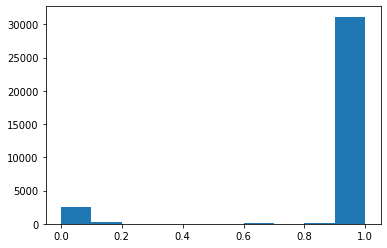

In [140]:
plt.hist(pred)

most from raw data are technical data. 

### plot no. of soft skills vs. quantile between [0.01, 0.2]

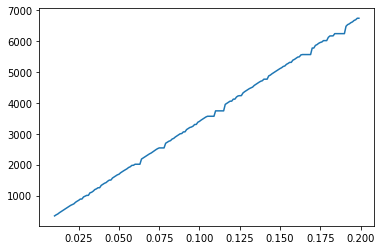

In [141]:
plt.plot(np.arange(0.01, 0.2, 0.001) , [np.sum(np.where(pred < np.quantile(pred, r), 1, 0)) for r in np.arange(0.01, 0.2, 0.001)])

### add 'pred' column to dataframe

In [142]:
test_raw = raw_skills.copy()
pred = [float(i) for i in pred]
test_raw['pred'] = pred

In [143]:
soft_skills = list(test_raw[test_raw['pred'] < 0.1].sort_values(by='pred')['RAW DATA'])


##predicted soft skill. 

In [144]:
list(set(soft_skills))

['Quality Assurance',
 'strong negotiation',
 'a concise and effective manner',
 'daily workload',
 'A thorough understanding',
 'Excellent organizational, verbal and written communication skills',
 'all deliverables',
 'excellent leadership qualities',
 'presentations',
 'the Agile teams',
 'new organizational standards',
 '#',
 ' Design Software or CAD experience',
 'the development lifecycle',
 'full software development lifecycle',
 'provided deadlines',
 'internal IT audit',
 'Excellent collaborative attitude',
 'Quality Assurance reports',
 'Strong technical documentation',
 ' Excellent communication and collaboration skills',
 'multiple deployment environments',
 'minimal team supervision',
 'your curiosity',
 'good organizational skills',
 'project deliverables',
 'Strong Linux knowledge',
 'Coordinate communication',
 'the Software Development Lifecycle',
 'Punctuality',
 'technical design and software architecture documentation',
 'the automated build process',
 'stakeholders

### see this done pretty nice thing on raw data so me technical skills misclassified due to lack of technical skills data.

In [145]:
test_raw.sort_values(by='pred', ascending=False).head(20)

,RAW DATA,pred
0,What ifs,1.0
19342,Python,1.0
19384,Hyperledger,1.0
19383,MVC architecture,1.0
19382,Docker/Kubernetes,1.0
19379,resource utilisation,1.0
19378,configurations,1.0
19375,•Provision cloud resources,1.0
19373,Confluence/Notion,1.0
19371,Github,1.0
